<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#histogram-stretch" data-toc-modified-id="histogram-stretch-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>histogram stretch</a></span></li></ul></div>

# histogram stretch

In [1]:
import a301
import pdb
from pathlib import Path
#import rasterio
from IPython.display import Image
from a301.landsat.landsat_metadata import landsat_metadata
from PIL import Image as pil_image
from PIL.TiffTags import TAGS
import numpy as np
from matplotlib import pyplot as plt
from skimage import data, img_as_float
from skimage import exposure

june_2015= a301.test_dir / Path('landsat8/LC80470262015165LGN02')
may_2015=a301.test_dir / Path("landsat_2018_05_13")
data_dir=may_2015
data_dir=june_2015
tiff_file=list(data_dir.glob("*B1.TIF"))[0]
meta_file=list(data_dir.glob("*MTL.txt"))[0]
#jpeg_file=list(data_dir.glob("*T1.jpg"))[0]
help(img_as_float)

Help on function img_as_float in module skimage.util.dtype:

img_as_float(image, force_copy=False)
    Convert an image to floating point format.
    
    This function is similar to `img_as_float64`, but will not convert
    lower-precision floating point arrays to `float64`.
    
    Parameters
    ----------
    image : ndarray
        Input image.
    force_copy : bool, optional
        Force a copy of the data, irrespective of its current dtype.
    
    Returns
    -------
    out : ndarray of float
        Output image.
    
    Notes
    -----
    The range of a floating point image is [0.0, 1.0] or [-1.0, 1.0] when
    converting from unsigned or signed datatypes, respectively.
    If the input image has a float type, intensity values are not modified
    and can be outside the ranges [0.0, 1.0] or [-1.0, 1.0].



In [2]:
out=landsat_metadata(meta_file)
meta_dict = out.__dict__

with pil_image.open(tiff_file) as img:
    tiff_meta_dict = {TAGS[key] : img.tag[key] for key in img.tag.keys()}
    ch1 = img_as_float(img)
    
img_eq = exposure.equalize_hist(ch1)    

Scene LC80470262015165LGN02 center time is 2015-06-14 19:00:43


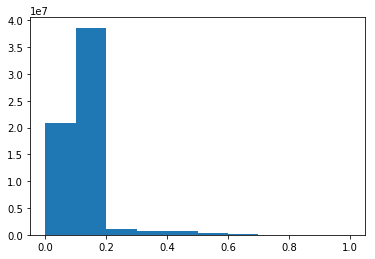

In [3]:
plt.hist(ch1.ravel());

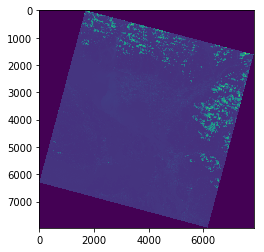

In [4]:
plt.imshow(ch1);

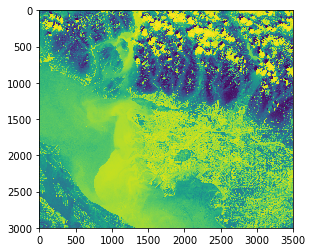

In [5]:
plt.imshow(img_eq[1000:4000,1500:5000],interpolation="nearest");

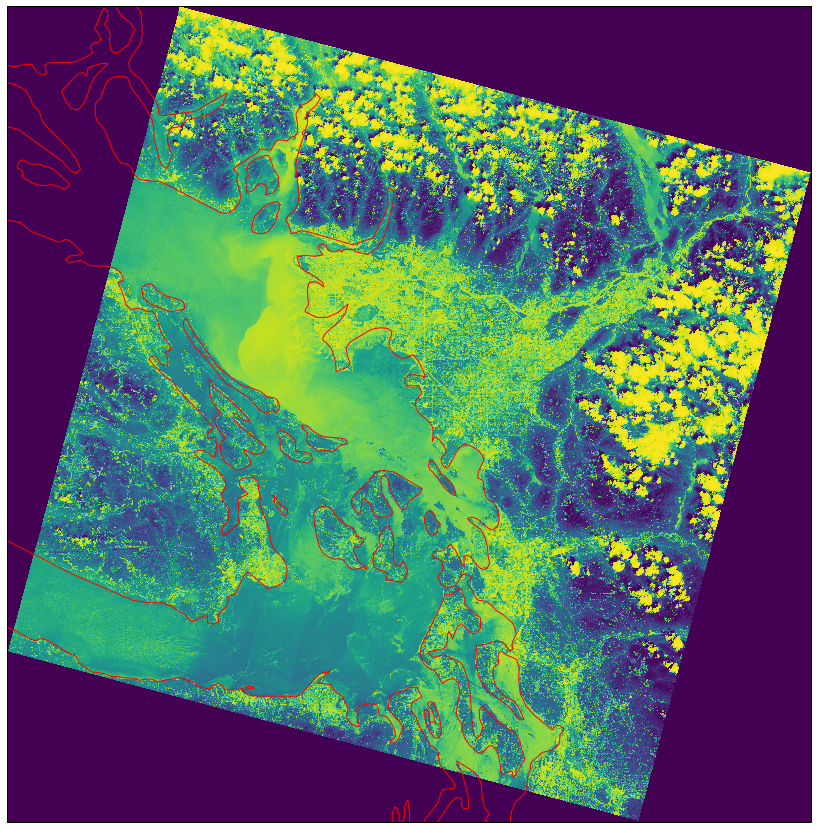

In [6]:
%matplotlib inline

xmin=meta_dict['CORNER_UL_PROJECTION_X_PRODUCT']
xmax=meta_dict['CORNER_UR_PROJECTION_X_PRODUCT']
ymax=meta_dict['CORNER_LL_PROJECTION_Y_PRODUCT']
ymin=meta_dict['CORNER_UL_PROJECTION_Y_PRODUCT']

from matplotlib import pyplot as plt
import cartopy
zone=meta_dict['UTM_ZONE']
zone_code = 32610
#https://epsg.io/32610
crs = cartopy.crs.epsg(zone_code)
fig, ax = plt.subplots(1, 1,figsize=[15,15],subplot_kw={'projection': crs})
ax.imshow(img_eq, origin='lower', extent=[xmin, xmax, ymin, ymax], transform=crs, 
          interpolation='nearest')
ax.coastlines(resolution='10m',color='red',lw=1)
ax.set_extent([xmin,xmax,ymin,ymax],crs)

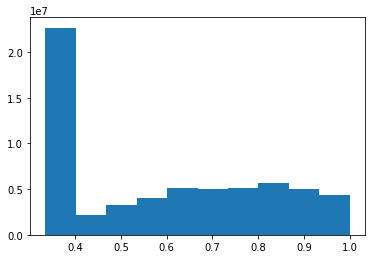

In [7]:
plt.hist(img_eq.ravel());

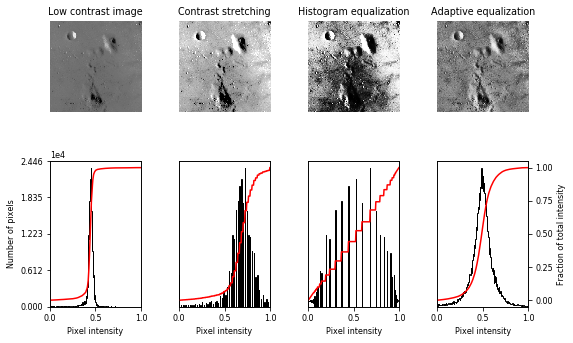

In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure


matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = data.moon()

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()